In [1]:
from dotenv import load_dotenv
load_dotenv()

True

## Breakpoints

In [2]:
from langchain_cerebras import ChatCerebras

In [3]:
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

# This will be a tool
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b

def divide(a: int, b: int) -> float:
    """Divide a by b.

    Args:
        a: first int
        b: second int
    """
    return a / b

tools = [add, multiply, divide]
llm = ChatCerebras(model="gpt-oss-120b")
llm_with_tools = llm.bind_tools(tools)

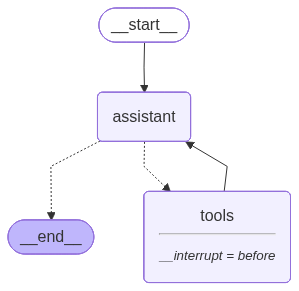

In [4]:
from IPython.display import Image, display

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import MessagesState
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition, ToolNode

from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

# System message
sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs.")

# Node
def assistant(state: MessagesState):
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

# Graph
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Define edges: these determine the control flow
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "assistant")

memory = MemorySaver()
graph = builder.compile(interrupt_before=["tools"], checkpointer=memory)

# Show
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [5]:
# Input
initial_input = {"messages": HumanMessage(content="Multiply 2 and 3")}

# Thread
thread = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in graph.stream(initial_input, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

Multiply 2 and 3
================================== Ai Message ==================================
Tool Calls:
  multiply (5902f8fb7)
 Call ID: 5902f8fb7
  Args:
    a: 2
    b: 3


In [6]:
state = graph.get_state(thread)
state.next

('tools',)

In [7]:
history = graph.get_state_history(thread)
for h in history:
    print(h)

StateSnapshot(values={'messages': [HumanMessage(content='Multiply 2 and 3', additional_kwargs={}, response_metadata={}, id='fcc3be2c-d3dd-4593-a895-f5cc5ef7bdca'), AIMessage(content='', additional_kwargs={'refusal': None, 'reasoning': 'The user wants multiplication of 2 and 3. Use the multiply function.'}, response_metadata={'token_usage': {'completion_tokens': 50, 'prompt_tokens': 209, 'total_tokens': 259, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': None, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-oss-120b', 'system_fingerprint': 'fp_e7ab83753cbd28777b40', 'id': 'chatcmpl-a58f89bf-d966-490b-8766-f807a8baebc0', 'finish_reason': 'tool_calls', 'logprobs': None}, id='lc_run--019bfaea-4edb-74a0-8630-3c05cd577b18-0', tool_calls=[{'name': 'multiply', 'args': {'a': 2, 'b': 3}, 'id': '5902f8fb7', 'type': 'tool_call'}], invalid_too

![breakpoints.jpg](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbae7985b747dfed67775d_breakpoints1.png)

In [8]:
for event in graph.stream(None, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  multiply (5902f8fb7)
 Call ID: 5902f8fb7
  Args:
    a: 2
    b: 3
================================= Tool Message =================================
Name: multiply

6
================================== Ai Message ==================================

6


In [9]:
# Input
initial_input = {"messages": HumanMessage(content="Multiply 2 and 3")}

# Thread
thread = {"configurable": {"thread_id": "2"}}

# Run the graph until the first interruption
for event in graph.stream(initial_input, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

# Get user feedback
user_approval = input("Do you want to call the tool? (yes/no): ")

# Check approval
if user_approval.lower() == "yes":
    
    # If approved, continue the graph execution
    for event in graph.stream(None, thread, stream_mode="values"):
        event['messages'][-1].pretty_print()
        
else:
    print("Operation cancelled by user.")

================================ Human Message =================================

Multiply 2 and 3
================================== Ai Message ==================================
Tool Calls:
  multiply (9e2d28580)
 Call ID: 9e2d28580
  Args:
    a: 2
    b: 3
================================== Ai Message ==================================
Tool Calls:
  multiply (9e2d28580)
 Call ID: 9e2d28580
  Args:
    a: 2
    b: 3
================================= Tool Message =================================
Name: multiply

6
================================== Ai Message ==================================

The result is **6**.


## Editing State and Human Feedback

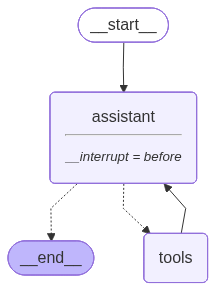

In [10]:
from IPython.display import Image, display

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import MessagesState
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition, ToolNode

from langchain_core.messages import HumanMessage, SystemMessage

# System message
sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs.")

# Node
def assistant(state: MessagesState):
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

# Graph
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Define edges: these determine the control flow
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "assistant")

memory = MemorySaver()
graph = builder.compile(interrupt_before=["assistant"], checkpointer=memory)

# Show
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [11]:
# Input
initial_input = {"messages": "Multiply 2 and 3"}

# Thread
thread = {"configurable": {"thread_id": "11"}}

# Run the graph until the first interruption
for event in graph.stream(initial_input, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

Multiply 2 and 3


In [12]:
state = graph.get_state(thread)
state.values

{'messages': [HumanMessage(content='Multiply 2 and 3', additional_kwargs={}, response_metadata={}, id='d896b577-887e-4b01-899d-8d5712fb868d')]}

In [13]:
graph.update_state(
    thread,
    {"messages": [HumanMessage(content="No, actually multiply 3 and 3!")]},
)

{'configurable': {'thread_id': '11',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0facc0-ebf1-6113-8001-25c5811db7ee'}}

In [14]:
new_state = graph.get_state(thread).values
for m in new_state['messages']:
    m.pretty_print()

================================ Human Message =================================

Multiply 2 and 3
================================ Human Message =================================

No, actually multiply 3 and 3!


In [15]:
for event in graph.stream(None, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

No, actually multiply 3 and 3!
================================== Ai Message ==================================
Tool Calls:
  multiply (af4d6c0d8)
 Call ID: af4d6c0d8
  Args:
    a: 3
    b: 3
================================= Tool Message =================================
Name: multiply

9


## Dynamic Breakpoints

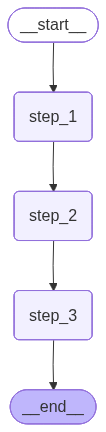

In [16]:
from IPython.display import Image, display

from typing_extensions import TypedDict
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import START, END, StateGraph
from langgraph.types import interrupt

class State(TypedDict):
    input: str

def step_1(state: State) -> State:
    print("---Step 1---")
    return state

def step_2(state: State) -> State:
    # Let's optionally raise a NodeInterrupt if the length of the input is longer than 5 characters
    if len(state['input']) > 5:
        interrupt(f"Received input that is longer than 5 characters: {state['input']}")
    
    print("---Step 2---")
    return state

def step_3(state: State) -> State:
    print("---Step 3---")
    return state

builder = StateGraph(State)
builder.add_node("step_1", step_1)
builder.add_node("step_2", step_2)
builder.add_node("step_3", step_3)
builder.add_edge(START, "step_1")
builder.add_edge("step_1", "step_2")
builder.add_edge("step_2", "step_3")
builder.add_edge("step_3", END)

# Set up memory
memory = MemorySaver()

# Compile the graph with memory
graph = builder.compile(checkpointer=memory)

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [17]:
initial_input = {"input": "hello world"}
thread_config = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in graph.stream(initial_input, thread_config, stream_mode="values"):
    print(event)

{'input': 'hello world'}
---Step 1---
{'input': 'hello world'}
{'input': 'hello world', '__interrupt__': (Interrupt(value='Received input that is longer than 5 characters: hello world', id='a4385e6096e971c9645f17ddfaa2433a'),)}


In [18]:
state = graph.get_state(thread_config)
print(state.next)

('step_2',)


In [19]:
print(state.tasks)

(PregelTask(id='2e0c5d24-8df1-89ea-0717-a9137b40edd3', name='step_2', path=('__pregel_pull', 'step_2'), error=None, interrupts=(Interrupt(value='Received input that is longer than 5 characters: hello world', id='a4385e6096e971c9645f17ddfaa2433a'),), state=None, result=None),)


In [20]:
for event in graph.stream(None, thread_config, stream_mode="values"):
    print(event)

{'input': 'hello world'}
{'input': 'hello world', '__interrupt__': (Interrupt(value='Received input that is longer than 5 characters: hello world', id='a4385e6096e971c9645f17ddfaa2433a'),)}


In [21]:
state = graph.get_state(thread_config)
print(state.next)

('step_2',)


In [22]:
graph.update_state(
    thread_config,
    {"input": "hi"},
)

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0facc6-c2ed-63bf-8002-a91b4fe30dfc'}}

In [23]:
for event in graph.stream(None, thread_config, stream_mode="values"):
    print(event)

{'input': 'hi'}
---Step 2---
{'input': 'hi'}
---Step 3---
{'input': 'hi'}


## Time Travel

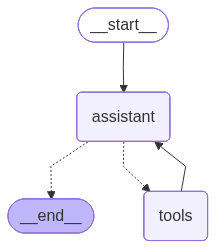

In [24]:
from IPython.display import Image, display

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import MessagesState
from langgraph.graph import START, END, StateGraph
from langgraph.prebuilt import tools_condition, ToolNode

from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

# System message
sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs.")

# Node
def assistant(state: MessagesState):
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

# Graph
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Define edges: these determine the control flow
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "assistant")

memory = MemorySaver()
graph = builder.compile(checkpointer=MemorySaver())

# Show
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [25]:
# Input
initial_input = {"messages": HumanMessage(content="Multiply 2 and 3")}

# Thread
thread = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in graph.stream(initial_input, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

Multiply 2 and 3
================================== Ai Message ==================================
Tool Calls:
  multiply (fefb3c2e0)
 Call ID: fefb3c2e0
  Args:
    a: 2
    b: 3
================================= Tool Message =================================
Name: multiply

6
================================== Ai Message ==================================

The product of 2 and 3 is **6**.


In [26]:
graph.get_state({'configurable': {'thread_id': '1'}})

StateSnapshot(values={'messages': [HumanMessage(content='Multiply 2 and 3', additional_kwargs={}, response_metadata={}, id='a636f372-0c77-4d29-a70f-f41d5ee803cf'), AIMessage(content='', additional_kwargs={'refusal': None, 'reasoning': 'We need to call multiply function with a=2, b=3.'}, response_metadata={'token_usage': {'completion_tokens': 49, 'prompt_tokens': 209, 'total_tokens': 258, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': None, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-oss-120b', 'system_fingerprint': 'fp_e7ab83753cbd28777b40', 'id': 'chatcmpl-0155dcf9-52ab-40d0-8a81-2100a7722aea', 'finish_reason': 'tool_calls', 'logprobs': None}, id='lc_run--019bfaf2-2127-7e40-a9c5-db79f397de8c-0', tool_calls=[{'name': 'multiply', 'args': {'a': 2, 'b': 3}, 'id': 'fefb3c2e0', 'type': 'tool_call'}], invalid_tool_calls=[], usage_me

In [27]:
all_states = [s for s in graph.get_state_history(thread)]

In [28]:
len(all_states)

5

In [29]:
for i in range(len(all_states)):
    print(f"--- State {i} ---")
    print(f"values: {all_states[i].values['messages']}")
    print(f"next: {all_states[i].next}")
    print("-"*25)

--- State 0 ---
values: [HumanMessage(content='Multiply 2 and 3', additional_kwargs={}, response_metadata={}, id='a636f372-0c77-4d29-a70f-f41d5ee803cf'), AIMessage(content='', additional_kwargs={'refusal': None, 'reasoning': 'We need to call multiply function with a=2, b=3.'}, response_metadata={'token_usage': {'completion_tokens': 49, 'prompt_tokens': 209, 'total_tokens': 258, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': None, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-oss-120b', 'system_fingerprint': 'fp_e7ab83753cbd28777b40', 'id': 'chatcmpl-0155dcf9-52ab-40d0-8a81-2100a7722aea', 'finish_reason': 'tool_calls', 'logprobs': None}, id='lc_run--019bfaf2-2127-7e40-a9c5-db79f397de8c-0', tool_calls=[{'name': 'multiply', 'args': {'a': 2, 'b': 3}, 'id': 'fefb3c2e0', 'type': 'tool_call'}], invalid_tool_calls=[], usage_metadata={'i

In [30]:
all_states[-2]

StateSnapshot(values={'messages': [HumanMessage(content='Multiply 2 and 3', additional_kwargs={}, response_metadata={}, id='a636f372-0c77-4d29-a70f-f41d5ee803cf')]}, next=('assistant',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0facca-5b02-6a93-8000-0bb636ea4ffb'}}, metadata={'source': 'loop', 'step': 0, 'parents': {}}, created_at='2026-01-26T15:35:30.854357+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0facca-5b01-6955-bfff-ba3c4776d00c'}}, tasks=(PregelTask(id='482e9f0c-896e-f2c7-2e1a-3e85f3e5487c', name='assistant', path=('__pregel_pull', 'assistant'), error=None, interrupts=(), state=None, result={'messages': [AIMessage(content='', additional_kwargs={'refusal': None, 'reasoning': 'We need to call multiply function with a=2, b=3.'}, response_metadata={'token_usage': {'completion_tokens': 49, 'prompt_tokens': 209, 'total_tokens': 258, 'completion_tokens_details': {'accepted_prediction_toke

![fig2.jpg](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbb038a0bd34b541c78fb8_time-travel2.png)

In [31]:
to_replay = all_states[-2]

In [32]:
to_replay.values

{'messages': [HumanMessage(content='Multiply 2 and 3', additional_kwargs={}, response_metadata={}, id='a636f372-0c77-4d29-a70f-f41d5ee803cf')]}

In [33]:
to_replay.next

('assistant',)

In [34]:
to_replay.config

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0facca-5b02-6a93-8000-0bb636ea4ffb'}}

In [35]:
for event in graph.stream(None, to_replay.config, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

Multiply 2 and 3
================================== Ai Message ==================================
Tool Calls:
  multiply (daa8b6dae)
 Call ID: daa8b6dae
  Args:
    a: 2
    b: 3
================================= Tool Message =================================
Name: multiply

6
================================== Ai Message ==================================

The result of multiplying 2 by 3 is **6**.


### Forking

![fig3.jpg](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbb038f89f2d847ee5c336_time-travel3.png)

In [36]:
to_fork = all_states[-2]
to_fork.values["messages"]

[HumanMessage(content='Multiply 2 and 3', additional_kwargs={}, response_metadata={}, id='a636f372-0c77-4d29-a70f-f41d5ee803cf')]

In [37]:
to_fork.config

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0facca-5b02-6a93-8000-0bb636ea4ffb'}}

In [38]:
fork_config = graph.update_state(
    to_fork.config,
    {"messages": [HumanMessage(content='Multiply 5 and 3', 
                               id=to_fork.values["messages"][0].id)]},
)

In [39]:
all_states = [state for state in graph.get_state_history(thread) ]
all_states[0].values["messages"]

[HumanMessage(content='Multiply 5 and 3', additional_kwargs={}, response_metadata={}, id='a636f372-0c77-4d29-a70f-f41d5ee803cf')]

In [40]:
len(all_states)

9

In [41]:
graph.get_state({'configurable': {'thread_id': '1'}})

StateSnapshot(values={'messages': [HumanMessage(content='Multiply 5 and 3', additional_kwargs={}, response_metadata={}, id='a636f372-0c77-4d29-a70f-f41d5ee803cf')]}, next=('assistant',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0faccf-ef2b-6adc-8001-f3fb7f1654ea'}}, metadata={'source': 'update', 'step': 1, 'parents': {}}, created_at='2026-01-26T15:38:00.607806+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0facca-5b02-6a93-8000-0bb636ea4ffb'}}, tasks=(PregelTask(id='bca311d5-815c-b097-923d-03782b4d75cc', name='assistant', path=('__pregel_pull', 'assistant'), error=None, interrupts=(), state=None, result=None),), interrupts=())

In [43]:
for event in graph.stream(None, fork_config, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

Multiply 5 and 3
================================== Ai Message ==================================
Tool Calls:
  multiply (915db2ec1)
 Call ID: 915db2ec1
  Args:
    a: 5
    b: 3
================================= Tool Message =================================
Name: multiply

15
================================== Ai Message ==================================

The product of 5 and 3 is **15**.


In [44]:
for m in graph.get_state({'configurable': {'thread_id': '1'}}).values["messages"]:
    m.pretty_print()   

================================ Human Message =================================

Multiply 5 and 3
================================== Ai Message ==================================
Tool Calls:
  multiply (915db2ec1)
 Call ID: 915db2ec1
  Args:
    a: 5
    b: 3
================================= Tool Message =================================
Name: multiply

15
================================== Ai Message ==================================

The product of 5 and 3 is **15**.
